In [17]:
import pandas as pd
import seaborn as sns
from common.utils import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = load_dataset("data/hotel_bookings.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [6]:
print(df.isnull().sum() / len(df))

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

In [7]:
df_num = df.select_dtypes(include=['int64', 'float64']).columns

In [8]:
df_obj = df.select_dtypes(include=['object', 'category'])

In [9]:
try:
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_prop = font_manager.FontProperties(fname=font_path, size=12)
    rc('font', family=font_prop.get_name())
except Exception as e:
    print(f"Error loading font: {e}")

In [10]:
plt.rcParams['axes.unicode_minus'] = False

In [11]:
correlation_matrix = df[df_num].corr()

In [12]:
cancellation_corr = correlation_matrix[['is_canceled']].sort_values(by='is_canceled', ascending=False)

In [19]:
# 코드 상단에 경고 무시 코드를 추가
warnings.filterwarnings('ignore')

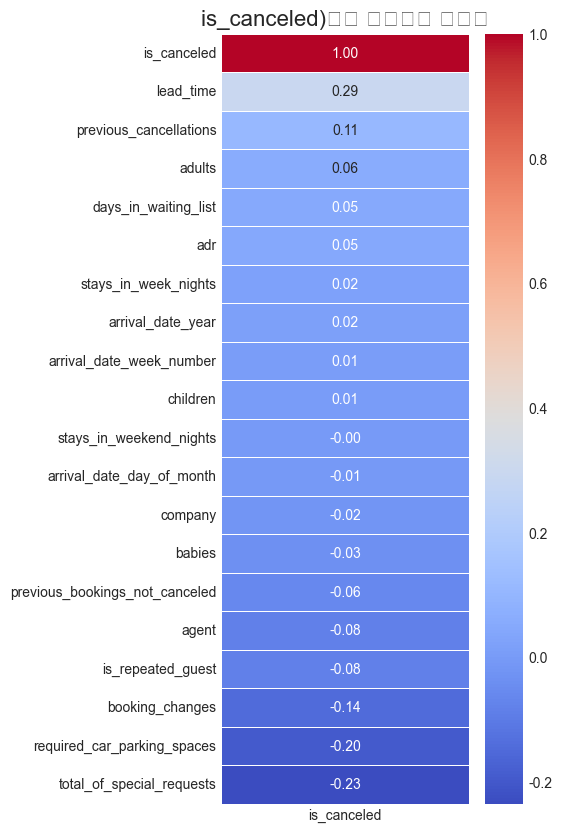

In [20]:
plt.figure(figsize=(4, 10))
heatmap = sns.heatmap(
    cancellation_corr,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)

plt.title('is_canceled)와의 상관관계 히트맵', fontsize=16)
plt.savefig('cancellation_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

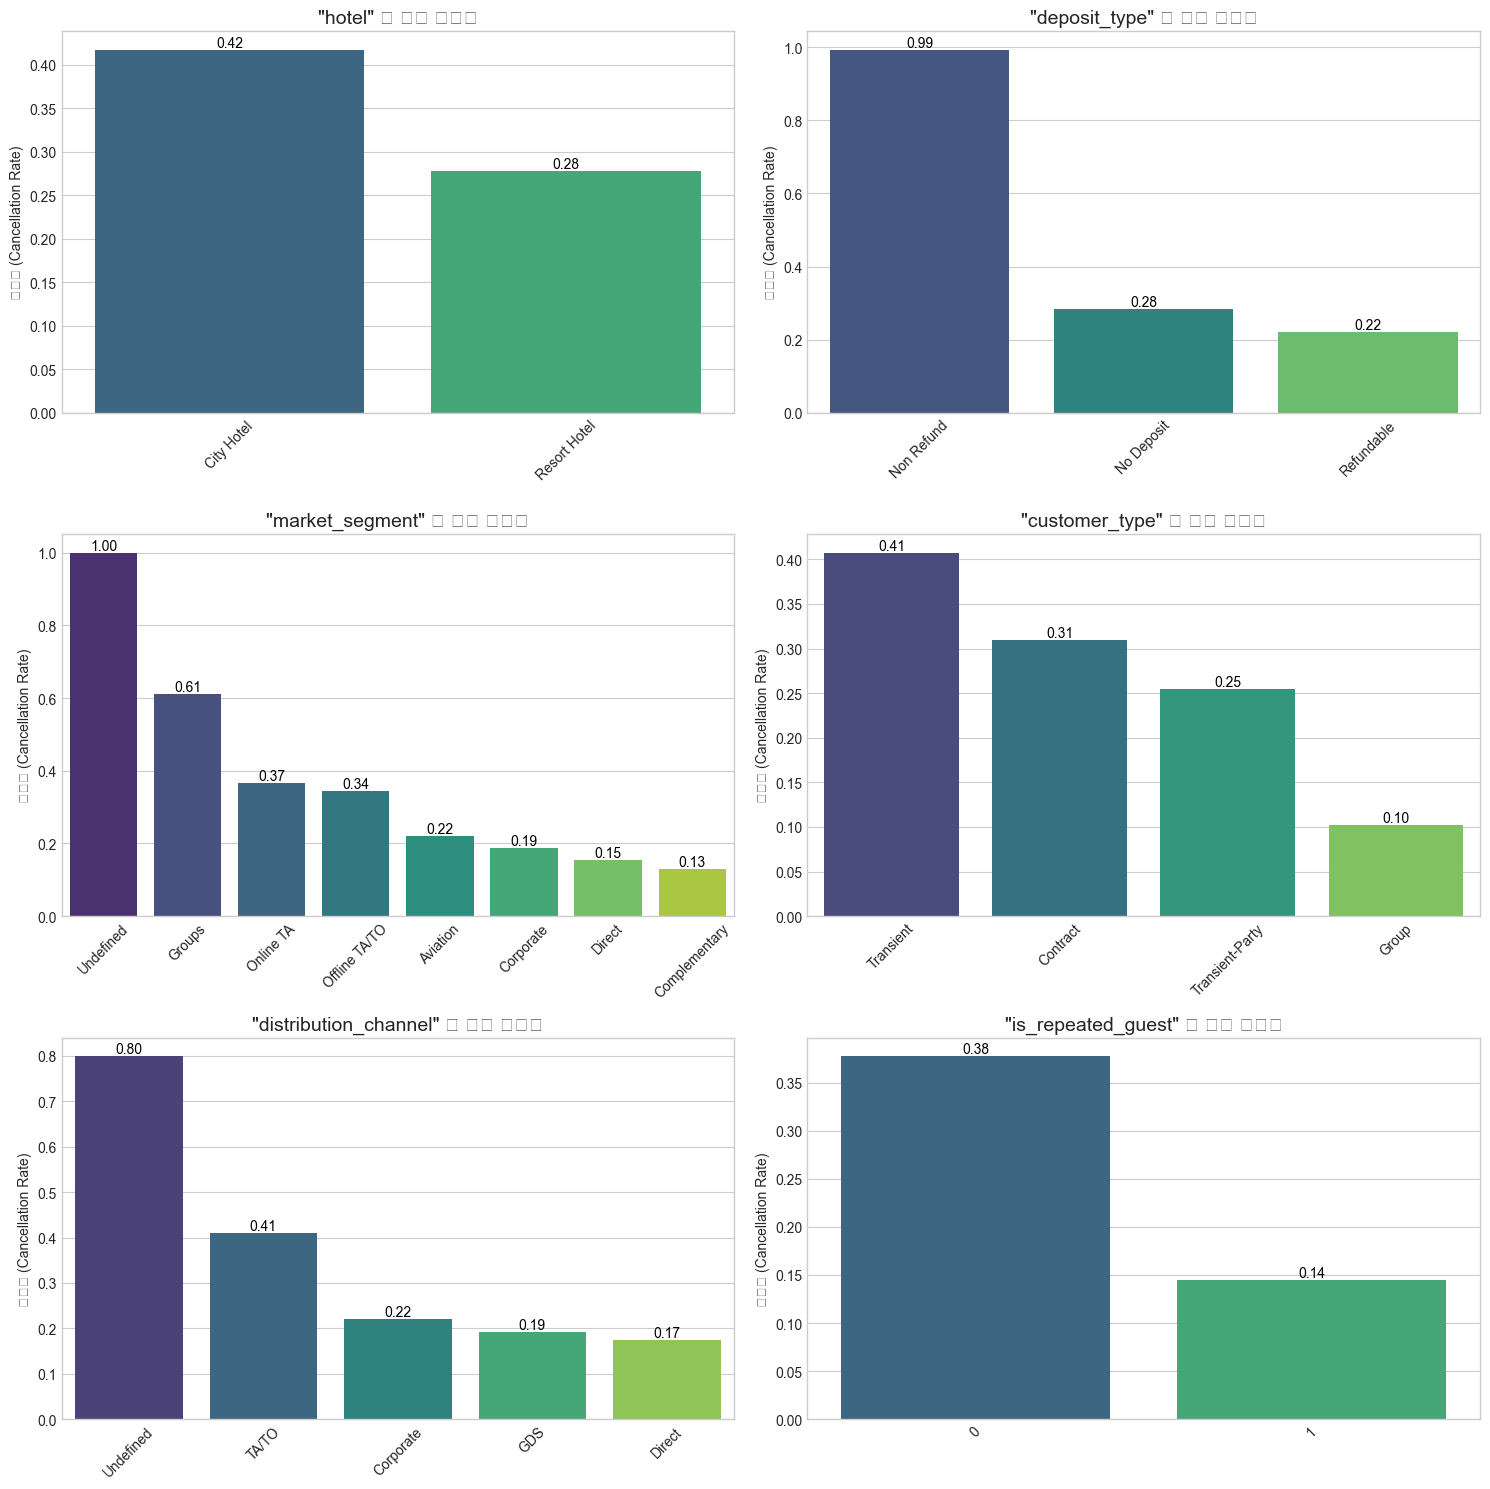

In [22]:
# 2. 분석할 주요 범주형 피처 선택
# 'is_repeated_guest'는 0/1이지만, '신규/재방문'이라는 범주로 해석할 수 있어 포함합니다.
categorical_features = [
    'hotel',
    'deposit_type',
    'market_segment',
    'customer_type',
    'distribution_channel',
    'is_repeated_guest'
]

# 3. 여러 그래프를 한 번에 그리기 위한 subplot 설정
# 3행 2열의 격자를 생성합니다.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# 격자에 맞춰 그래프 위치를 조정합니다.
axes = axes.flatten()

# 4. 각 피처별로 예약 취소율을 계산하고 시각화
for i, feature in enumerate(categorical_features):
    # 피처별로 그룹화하여 'is_canceled'의 평균(즉, 취소율)을 계산하고 정렬합니다.
    cancellation_rate = df.groupby(feature)['is_canceled'].mean().sort_values(ascending=False)

    # 막대그래프를 그립니다.
    sns.barplot(x=cancellation_rate.index, y=cancellation_rate.values, ax=axes[i], palette='viridis')
    axes[i].set_title(f'"{feature}" 별 예약 취소율', fontsize=14)
    axes[i].set_xlabel('') # x축 라벨은 생략
    axes[i].set_ylabel('취소율 (Cancellation Rate)')
    axes[i].tick_params(axis='x', rotation=45) # x축 카테고리 이름이 길면 45도 회전
    # 막대 위에 취소율 수치를 텍스트로 표시 (소수점 둘째자리까지)
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')


plt.tight_layout() # 그래프들이 겹치지 않게 레이아웃을 조정
plt.savefig('categorical_cancellation_rate.png')
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98514422.py:64: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98514422.py:64: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98514422.py:64: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98514422.py:64: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98514422.py:64: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12924\98

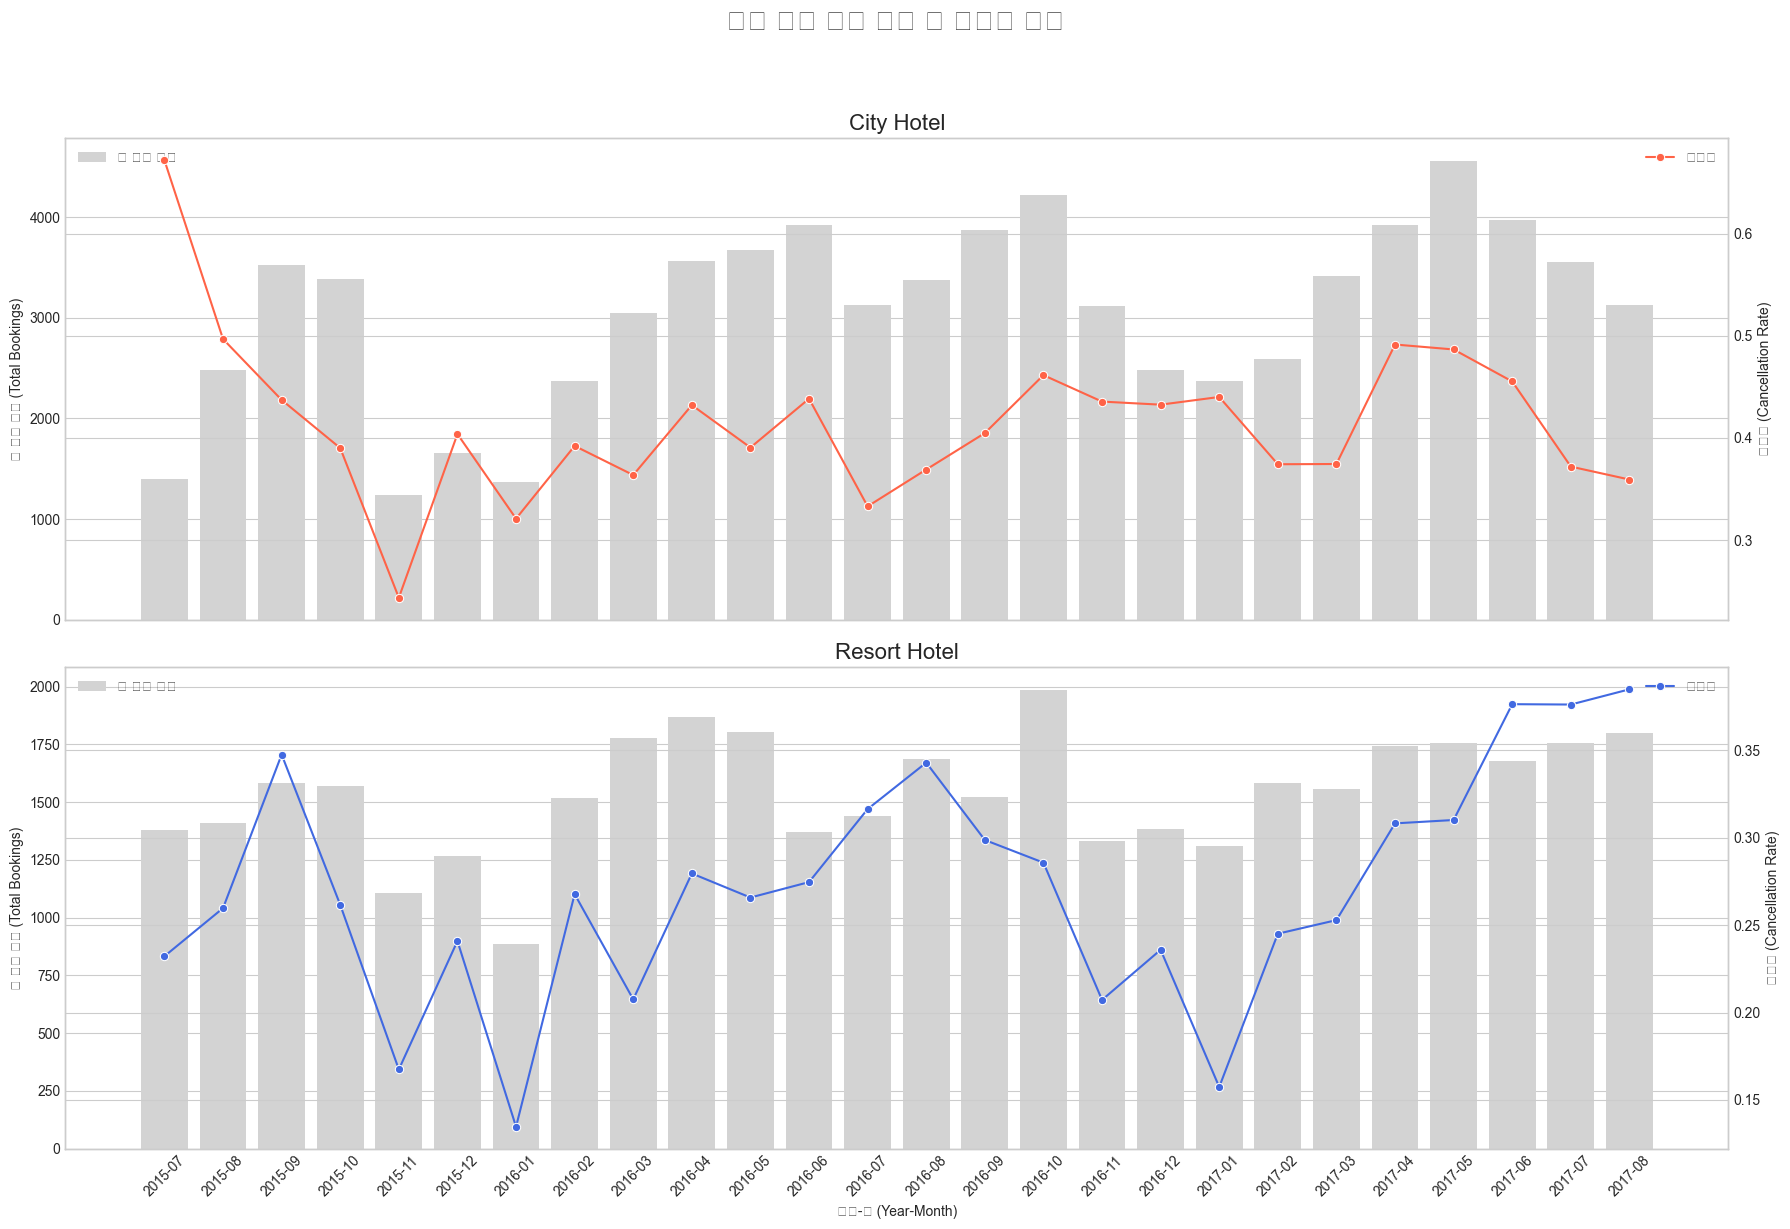

In [14]:
# 2. 월(Month) 데이터를 순서대로 정렬하기 위한 전처리
# 월 이름과 숫자 매핑
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['arrival_date_month_numeric'] = df['arrival_date_month'].map(month_map)

# 3. 년도와 월을 기준으로 데이터 집계(Aggregation)
# 호텔 종류, 년, 월별로 그룹화하여 예약 건수와 취소 건수를 계산
monthly_stats = df.groupby(['hotel', 'arrival_date_year', 'arrival_date_month_numeric']).agg(
    total_bookings=('is_canceled', 'count'), # 총 예약 건수
    canceled_bookings=('is_canceled', 'sum')   # 취소된 예약 건수 (is_canceled가 1인 경우의 합)
).reset_index()

# 취소율 컬럼 추가
monthly_stats['cancellation_rate'] = monthly_stats['canceled_bookings'] / monthly_stats['total_bookings']

# 4. 시각화를 위한 날짜(YYYY-MM) 컬럼 생성
monthly_stats['year_month'] = monthly_stats['arrival_date_year'].astype(str) + '-' + monthly_stats['arrival_date_month_numeric'].astype(str).str.zfill(2)
monthly_stats = monthly_stats.sort_values(by='year_month')

# 5. 시각화
# 오류가 발생한 스타일을 'seaborn-v0_8-whitegrid'로 수정
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True)
fig.suptitle('월별 호텔 예약 건수 및 취소율 추이', fontsize=20, y=1.02)

# City Hotel 그래프
city_hotel_data = monthly_stats[monthly_stats['hotel'] == 'City Hotel']
ax1_city = axes[0]
ax2_city = ax1_city.twinx() # Y축을 공유하는 두 번째 축 생성

sns.barplot(data=city_hotel_data, x='year_month', y='total_bookings', ax=ax1_city, color='lightgrey', label='총 예약 건수')
sns.lineplot(data=city_hotel_data, x='year_month', y='cancellation_rate', ax=ax2_city, color='tomato', marker='o', label='취소율')

ax1_city.set_title('City Hotel', fontsize=16)
ax1_city.set_ylabel('총 예약 건수 (Total Bookings)')
ax2_city.set_ylabel('취소율 (Cancellation Rate)')
ax1_city.tick_params(axis='x', rotation=45)
# 범례 추가
ax1_city.legend(loc='upper left')
ax2_city.legend(loc='upper right')


# Resort Hotel 그래프
resort_hotel_data = monthly_stats[monthly_stats['hotel'] == 'Resort Hotel']
ax1_resort = axes[1]
ax2_resort = ax1_resort.twinx()

sns.barplot(data=resort_hotel_data, x='year_month', y='total_bookings', ax=ax1_resort, color='lightgrey', label='총 예약 건수')
sns.lineplot(data=resort_hotel_data, x='year_month', y='cancellation_rate', ax=ax2_resort, color='royalblue', marker='o', label='취소율')

ax1_resort.set_title('Resort Hotel', fontsize=16)
ax1_resort.set_xlabel('년도-월 (Year-Month)')
ax1_resort.set_ylabel('총 예약 건수 (Total Bookings)')
ax2_resort.set_ylabel('취소율 (Cancellation Rate)')
ax1_resort.tick_params(axis='x', rotation=45)
# 범례 추가
ax1_resort.legend(loc='upper left')
ax2_resort.legend(loc='upper right')


plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('monthly_booking_trends.png')
plt.show()